# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV155"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv155')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv155/lv155-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 15:36:15,146 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
651,KEGG_AUTOIMMUNE_THYROID_DISEASE,155,0.763499,0.029283,0.105096


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP027364, SRP052056, SRP027530, SRP050087, SRP048222, SRP042161, SRP014428, SRP028336, SRP013984, SRP007947, SRP057196, SRP004637, SRP047192, SRP060416, SRP012167, SRP029889, SRP050499, SRP055513, SRP014020, SRP015640, SRP009266, SRP006575, SRP009247, SRP043320, SRP052612, SRP059733, SRP060355, SRP014213, SRP056696, SRP055569, SRP047299, SRP041751, SRP011546, SRP063661, SRP042620, SRP008331, SRP009123, SRP036848, SRP062177, SRP035387, SRP066834, SRP040998, SRP003901, SRP029207, SRP007412, SRP065559, SRP024244, SRP019936, SRP064259, SRP024268, SRP056049, SRP058626, SRP061881, SRP036821, SRP023262, SRP009862, SRP050551, SRP033248, SRP045276, SRP013389, SRP057205, SRP063840, SRP017777, SRP032833, SRP048744, SRP052740, SRP040694, SRP025982, SRP012557, SRP011054, SRP017575, SRP019994, SRP055392, SRP039694, SRP044042, SRP037778, SRP040442, SRP026537, SRP059379, SRP033135, SRP042184, SRP059732, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (78 != 82)
  warnings.warn(


In [19]:
lv_data.shape

(8580, 137)

In [20]:
lv_data.head()

disease state   tissue sample type diagnosis  age  Sex  \
project   run                                                                
SRP027364 SRR934360        Normal  thyroid         NaN       NaN  NaN  NaN   
          SRR934363        Normal  thyroid         NaN       NaN  NaN  NaN   
          SRR934362        Normal  thyroid         NaN       NaN  NaN  NaN   
          SRR934364        Normal  thyroid         NaN       NaN  NaN  NaN   
          SRR934365         Tumor  thyroid         NaN       NaN  NaN  NaN   

                    tumor stage genotype/variation sequenced molecule patient  \
project   run                                                                   
SRP027364 SRR934360         NaN                NaN                NaN     NaN   
          SRR934363         NaN                NaN                NaN     NaN   
          SRR934362         NaN                NaN                NaN     NaN   
          SRR934364         NaN                NaN                NaN     NaN   
          SRR934365         NaN                NaN                NaN     NaN   

                     ... reprogramming vector hour post serum-switch debris  \
project   run        ...                                                      
SRP027364 SRR934360  ...                  NaN                    NaN    NaN   
          SRR934363  ...                  NaN                    NaN    NaN   
          SRR934362  ...                  NaN                    NaN    NaN   
          SRR934364  ...                  NaN                    NaN    NaN   
          SRR934365  ...                  NaN                    NaN    NaN   

                    control well cells in well library protocol  \
project   run                                                     
SRP027364 SRR934360          NaN           NaN              NaN   
          SRR934363          NaN           NaN              NaN   
          SRR934362          NaN           NaN              NaN   
          SRR934364          NaN           NaN              NaN   
          SRR934365          NaN           NaN              NaN   

                    age at diagnosis final gtf2i mutation status  \
project   run                                                      
SRP027364 SRR934360              NaN                         NaN   
          SRR934363              NaN                         NaN   
          SRR934362              NaN                         NaN   
          SRR934364              NaN                         NaN   
          SRR934365              NaN                         NaN   

                    who histotype     LV155  
project   run                                
SRP027364 SRR934360           NaN  2.574352  
          SRR934363           NaN  2.472909  
          SRR934362           NaN  1.906772  
          SRR934364           NaN  1.255682  
          SRR934365           NaN  0.827064  

[5 rows x 137 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

diagnosis             0.524270
genotype/variation    0.279617
sample type           0.264167
sequenced molecule    0.245077
disease state         0.200362
patient               0.192348
tumor stage           0.187481
Sex                   0.081986
tissue                0.052514
age                   0.031987
cell sorted           0.013377
time in culture       0.013377
antibody              0.005676
passages              0.005676
age (years)           0.005285
strain/background     0.005285
cell type             0.004149
cancer or normal      0.003353
isolate               0.002373
brain region          0.002373
dtype: float64

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

tissue            0.052514
cell type         0.004149
cell subtype      0.001399
tissue subtype    0.000995
tissue type       0.000772
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "tissue",
        "cell subtype",
        "tissue subtype",
        "tissue type",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[2]

cell type  \
project   run                                                      
SRP027530 SRR935667                                          NaN   
SRP048222 SRR1799839                                      normal   
SRP027530 SRR935662                                          NaN   
SRP052056 SRR1754123                                         NaN   
SRP048222 SRR1799840                                       tumor   
SRP052056 SRR1754120                                         NaN   
SRP027364 SRR934365                                          NaN   
          SRR934370                                          NaN   
SRP027530 SRR935672                                          NaN   
          SRR935668                                          NaN   
          SRR935663                                          NaN   
SRP042161 SRR1294642                                Glioblastoma   
          SRR1295338                      Gliomasphere Cell Line   
SRP027530 SRR935675                                          NaN   
          SRR935679                                          NaN   
SRP052056 SRR1754118                                         NaN   
SRP027530 SRR935677                                          NaN   
          SRR935680                                          NaN   
          SRR935674                                          NaN   
SRP050087 SRR1658413                                         NaN   
SRP042161 SRR1295005                                Glioblastoma   
SRP027530 SRR935670                                          NaN   
SRP052056 SRR1754117                                         NaN   
          SRR1754124                                         NaN   
SRP014428 SRR522079   leukocyte from blood of healthy individual   

                              tissue cell subtype tissue subtype tissue type  \
project   run                                                                  
SRP027530 SRR935667   Thyroid cancer          NaN            NaN         NaN   
SRP048222 SRR1799839             NaN          NaN            NaN         NaN   
SRP027530 SRR935662   Thyroid cancer          NaN            NaN         NaN   
SRP052056 SRR1754123         thyroid          NaN            NaN         NaN   
SRP048222 SRR1799840             NaN          NaN            NaN         NaN   
SRP052056 SRR1754120         thyroid          NaN            NaN         NaN   
SRP027364 SRR934365          thyroid          NaN            NaN         NaN   
          SRR934370          thyroid          NaN            NaN         NaN   
SRP027530 SRR935672   Thyroid cancer          NaN            NaN         NaN   
          SRR935668   Thyroid cancer          NaN            NaN         NaN   
          SRR935663   Thyroid cancer          NaN            NaN         NaN   
SRP042161 SRR1294642             NaN          NaN            NaN         NaN   
          SRR1295338             NaN          NaN            NaN         NaN   
SRP027530 SRR935675   Thyroid cancer          NaN            NaN         NaN   
          SRR935679   Thyroid cancer          NaN            NaN         NaN   
SRP052056 SRR1754118         thyroid          NaN            NaN         NaN   
SRP027530 SRR935677   Thyroid cancer          NaN            NaN         NaN   
          SRR935680   Thyroid cancer          NaN            NaN         NaN   
          SRR935674   Thyroid cancer          NaN            NaN         NaN   
SRP050087 SRR1658413   Thyroid tumor          NaN            NaN         NaN   
SRP042161 SRR1295005             NaN          NaN            NaN         NaN   
SRP027530 SRR935670   Thyroid cancer          NaN            NaN         NaN   
SRP052056 SRR1754117         thyroid          NaN            NaN         NaN   
          SRR1754124         thyroid          NaN            NaN         NaN   
SRP014428 SRR522079              NaN          NaN            NaN         NaN   

                         LV155  
project   run           

In [26]:
# what is there in these projects?
lv_data.loc[["SRP048222"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

patient cell type     LV155
project   run                                                         
SRP048222 SRR1799841  follicular thyroid carcinoma    normal  1.443383
          SRR1799843  follicular thyroid carcinoma     tumor  1.406506
          SRR1799842  follicular thyroid carcinoma    normal  1.395537
          SRR1799844  follicular thyroid carcinoma     tumor  1.354286
          SRR1799837  follicular thyroid carcinoma    normal  0.988043
          SRR1799838  follicular thyroid carcinoma     tumor  0.957672
          SRR1799839  follicular thyroid carcinoma    normal  0.931947
          SRR1799840  follicular thyroid carcinoma     tumor  0.916409

In [27]:
SELECTED_ATTRIBUTE = "tissue"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["cell type"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

tissue     LV155
project   run                                 
SRP027364 SRR934369          thyroid  3.359463
SRP052056 SRR1754130         thyroid  3.171966
SRP027364 SRR934361          thyroid  2.799012
          SRR934360          thyroid  2.574352
          SRR934363          thyroid  2.472909
SRP052056 SRR1754137         thyroid  2.413360
SRP027530 SRR935676   Thyroid cancer  2.209648
SRP052056 SRR1754133         thyroid  2.078247
          SRR1754135         thyroid  2.039672
          SRR1754131         thyroid  1.931846
SRP027364 SRR934362          thyroid  1.906772
SRP052056 SRR1754134         thyroid  1.893236
SRP050087 SRR1658422  Normal Thyroid  1.802816
          SRR1658411   Thyroid tumor  1.796624
SRP027530 SRR935665   Thyroid cancer  1.775435
SRP050087 SRR1658417  Normal Thyroid  1.762835
          SRR1658424  Normal Thyroid  1.750950
SRP027364 SRR934368          thyroid  1.723000
          SRR934367          thyroid  1.716891
SRP052056 SRR1754136         thyroid  1.673208

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            "mixture of U87 human glioma cells and WI-38 human lung fibroblast cells": "Glioma cells + lung fibroblast cells",
            "mixture of U87 human glioma cells and MCF10a human breast cancer cells": "Glioma cells + breast cancer cells",
        }
    }
)

# plot_data = plot_data[plot_data[SELECTED_ATTRIBUTE] != "no cell"]

In [34]:
# add also tissue information to these projects
_srp_code = "SRP048222"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: lv_data.loc[(_srp_code, x.name), "patient"]
    + f" ({lv_data.loc[(_srp_code, x.name), 'cell type']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-34-ee0d85001ba1>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [35]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [36]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [37]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [38]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [39]:
len(attr_order)

25

In [40]:
attr_order[:5]

['thyroid',
 'Thyroid cancer',
 'Normal Thyroid',
 'Thyroid tumor',
 'follicular thyroid carcinoma (normal)']

## Plot

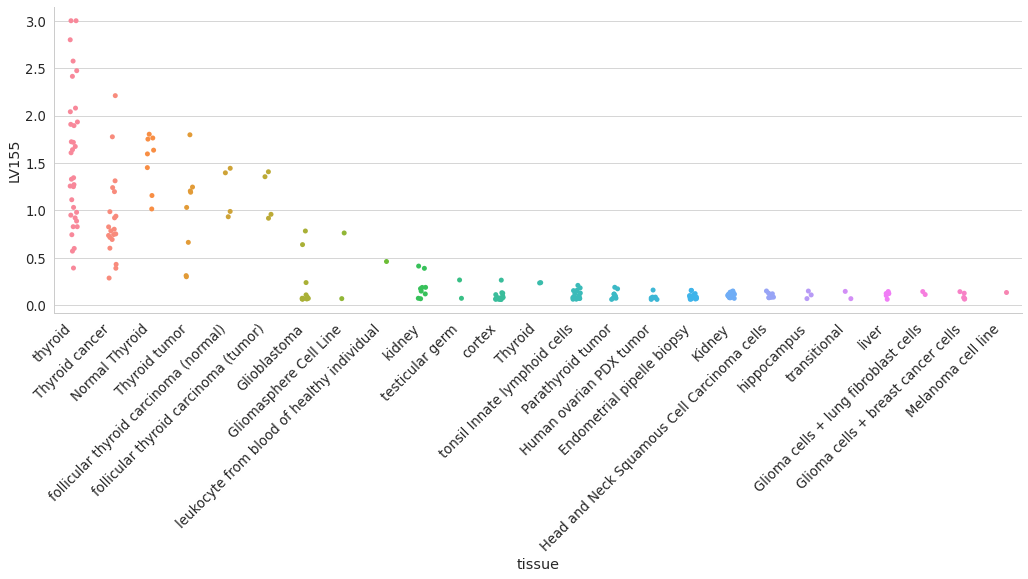

In [41]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [42]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("NOT CAT")]
#     display(_tmp.head(20))

In [43]:
# # what is there in these projects?
# lv_data.loc[["SRP050499"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)